In [1]:
# `cnn_4_llm_memo`

# Copyright 2025-present Laboratoire d'Informatique de Polytechnique.
# Apache Licence v2.0.

import os

os.chdir(os.path.dirname(os.path.abspath('')))

**WARNING: you must login to the same wandb account as the one used to upload your experiments**

## Setup

In [2]:
import src

In [3]:
from src.utils import paths
from src.detect import DetectConfig
from src.patterns import PatternsConfig, get_titles

In [4]:
from datetime import datetime

import torch
import wandb
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick

In [ ]:
# You can use the following to declare your base output dir if it is not ./output

# import os
# os.environ["_BASE_OUTPUT_DIR"] = "/lustre/fsn1/projects/rech/yfw/upp42qa/output_regu_detect"

In [5]:
def get_rouge_title(rouge_type, rouge_threshold):

    rouge_type_dict = {
        0: "Rouge L + Rouge 3",
        1: "Rouge L",
        2: "Rouge 3",
    }
    
    return f"{rouge_type_dict[rouge_type]} : {rouge_threshold:.1f}"


In [6]:
COMMON_TAX_NAME = "merge_2_other_guess_recollect_recite"

## Wandb load

In [7]:
api = wandb.Api()

In [8]:
project_name = "regu_detect"
runs = api.runs(
    project_name,
    filters={
        "group": "optimize_rho",
    }
)
runs = [
    r
    for r in runs
    if r.summary["_timestamp"] > datetime(2025, 3, 25, 0, 0, 0, 0).timestamp()
]
print(len(runs))

648


In [9]:
data = []

for r in tqdm(runs):

    detect_config = DetectConfig.autoconfig(r.name[:4], reset_output_dir=True)
    patterns_config = PatternsConfig.autoconfig(detect_config.patterns_config, reset_output_dir=True)
    history_df = r.history()
    num_classes = len([c for c in history_df.columns if "per_class_accuracy." in c])
    to_append = dict(
        run_id=r.id,
        detect_cfg=detect_config.get_id(),
        patterns_cfg=r.config["patterns_config"],
        detection_hash=r.config["detection_hash"],
        tax_name=patterns_config.tax_name,
        n_feat_cnn=r.config["n_feat_cnn"],
        kernel_size=r.config["kernel_size"],
        head_pooling=r.config["head_pooling"],
        num_classes=num_classes,
        patterns_size=r.config["patterns_size"],
        patterns_duplicates_threshold=r.config["patterns_duplicates_threshold"],
        patterns_rouge_threshold=r.config["patterns_rouge_threshold"],

    )

    for step in range(1, r.summary["_step"] + 1):
        to_append[f"train_loss_{step}"] = history_df.loc[step, "train_loss"]
        to_append[f"eval_loss_{step}"] = history_df.loc[step, "eval_loss"]
        to_append[f"overall_accuracy_{step}"] = history_df.loc[step, "overall_accuracy"]
    
    data.append(to_append)


100%|██████████| 648/648 [04:22<00:00,  2.47it/s]


In [10]:
df = pd.DataFrame(data)
df

,run_id,detect_cfg,patterns_cfg,detection_hash,tax_name,n_feat_cnn,kernel_size,head_pooling,num_classes,patterns_size,...,patterns_rouge_threshold,train_loss_1,eval_loss_1,overall_accuracy_1,train_loss_2,eval_loss_2,overall_accuracy_2,train_loss_3,eval_loss_3,overall_accuracy_3
0,p7tu1n1b,93-ivVCLlxepLrT1p2jK0g,pBXl_koU-tF8rM7NFd5sbA,_460xJ7Xj-K8fuY2nhYhfw,merge_2_other_guess_recollect_recite,10,6,mean,3,12b,...,0.1,0.038661,0.039434,0.808833,0.028370,0.031397,0.831667,0.026098,0.031309,0.846667
1,ozixlyev,AfMda6BGNJvXPTtHeVfsLQ,XmiAJmbkqHZXqpqz043n0g,_460xJ7Xj-K8fuY2nhYhfw,merge_2_other_guess_recollect_recite,10,6,mean,3,12b,...,0.3,0.035872,0.032203,0.865000,0.022988,0.025021,0.892667,0.021201,0.021535,0.896667
2,g2czn2ny,FmnkvU2D3_OyEiOp_jIm2w,ergNApl7Is98szbFXohkyw,_460xJ7Xj-K8fuY2nhYhfw,merge_2_other_guess_recollect_recite,10,6,mean,3,12b,...,0.2,0.042590,0.037211,0.815667,0.027916,0.029680,0.857000,0.025409,0.029399,0.852833
3,o4jan9h6,FHBHl881QDzIf2lNWvg1Hw,d-j9HErXNy960ehYGg_eVQ,_460xJ7Xj-K8fuY2nhYhfw,merge_2_other_guess_recollect_recite,10,6,mean,3,12b,...,0.4,0.038465,0.024895,0.883333,0.021021,0.023556,0.898667,0.018457,0.019892,0.903667
4,kmlaukh0,_XPYnzIlsBp1TzX-8Hjxhg,yV6mcF82EQNMypxu9TWgEQ,_460xJ7Xj-K8fuY2nhYhfw,merge_2_other_guess_recollect_recite,10,6,mean,3,12b,...,0.5,0.033655,0.032363,0.891667,0.019317,0.023000,0.911667,0.017391,0.019710,0.912000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,4bhso0yo,Df9_SnhCrL2jB02qXZCOdA,fSwLzdPE_tBBTor-P-uwdw,yLjB2-fGaSi7roZyojygbQ,merge_2_other_guess_recollect_recite,16,6,max,3,2.8b,...,0.8,0.028599,0.026513,0.911000,0.017924,0.027085,0.918333,0.016683,0.025293,0.912167
644,xmonkr43,KSqzJLQwVFgUbDp4aOhjRQ,fSwLzdPE_tBBTor-P-uwdw,iGG8nj8wH6mcvuhwCjb3ow,merge_2_other_guess_recollect_recite,10,8,mean,3,2.8b,...,0.8,0.036943,0.033912,0.876333,0.021537,0.026608,0.908333,0.018445,0.024957,0.913000
645,fkrzosln,mQG-zHYlpeqAeorGT_FzYA,fSwLzdPE_tBBTor-P-uwdw,gpYtldPwRR9ZBaneI-23_A,merge_2_other_guess_recollect_recite,10,8,max,3,2.8b,...,0.8,0.031816,0.026886,0.909167,0.019080,0.039421,0.808667,0.017822,0.027693,0.910333
646,nstls8pv,quzgENU3dOfDeMO5DZlZZQ,fSwLzdPE_tBBTor-P-uwdw,dJ2YeckSA-Oj3SPTDY_dMw,merge_2_other_guess_recollect_recite,16,8,mean,3,2.8b,...,0.8,0.033845,0.032146,0.891500,0.020386,0.022537,0.912000,0.017673,0.020790,0.895500


In [11]:
detection_hash, counts = np.unique(df["detection_hash"], return_counts=True)
print(detection_hash, counts)

['FarDo9MIDjoNWFe_WKPV9Q' 'GoY1ApGWnKbHCaNUqawmsw'
 'UCJp0Sru6JlJZsQuDEiGXA' '_460xJ7Xj-K8fuY2nhYhfw'
 'dJ2YeckSA-Oj3SPTDY_dMw' 'gpYtldPwRR9ZBaneI-23_A'
 'iGG8nj8wH6mcvuhwCjb3ow' 'yLjB2-fGaSi7roZyojygbQ'] [81 81 81 81 81 81 81 81]


In [12]:
df

,run_id,detect_cfg,patterns_cfg,detection_hash,tax_name,n_feat_cnn,kernel_size,head_pooling,num_classes,patterns_size,...,patterns_rouge_threshold,train_loss_1,eval_loss_1,overall_accuracy_1,train_loss_2,eval_loss_2,overall_accuracy_2,train_loss_3,eval_loss_3,overall_accuracy_3
0,p7tu1n1b,93-ivVCLlxepLrT1p2jK0g,pBXl_koU-tF8rM7NFd5sbA,_460xJ7Xj-K8fuY2nhYhfw,merge_2_other_guess_recollect_recite,10,6,mean,3,12b,...,0.1,0.038661,0.039434,0.808833,0.028370,0.031397,0.831667,0.026098,0.031309,0.846667
1,ozixlyev,AfMda6BGNJvXPTtHeVfsLQ,XmiAJmbkqHZXqpqz043n0g,_460xJ7Xj-K8fuY2nhYhfw,merge_2_other_guess_recollect_recite,10,6,mean,3,12b,...,0.3,0.035872,0.032203,0.865000,0.022988,0.025021,0.892667,0.021201,0.021535,0.896667
2,g2czn2ny,FmnkvU2D3_OyEiOp_jIm2w,ergNApl7Is98szbFXohkyw,_460xJ7Xj-K8fuY2nhYhfw,merge_2_other_guess_recollect_recite,10,6,mean,3,12b,...,0.2,0.042590,0.037211,0.815667,0.027916,0.029680,0.857000,0.025409,0.029399,0.852833
3,o4jan9h6,FHBHl881QDzIf2lNWvg1Hw,d-j9HErXNy960ehYGg_eVQ,_460xJ7Xj-K8fuY2nhYhfw,merge_2_other_guess_recollect_recite,10,6,mean,3,12b,...,0.4,0.038465,0.024895,0.883333,0.021021,0.023556,0.898667,0.018457,0.019892,0.903667
4,kmlaukh0,_XPYnzIlsBp1TzX-8Hjxhg,yV6mcF82EQNMypxu9TWgEQ,_460xJ7Xj-K8fuY2nhYhfw,merge_2_other_guess_recollect_recite,10,6,mean,3,12b,...,0.5,0.033655,0.032363,0.891667,0.019317,0.023000,0.911667,0.017391,0.019710,0.912000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,4bhso0yo,Df9_SnhCrL2jB02qXZCOdA,fSwLzdPE_tBBTor-P-uwdw,yLjB2-fGaSi7roZyojygbQ,merge_2_other_guess_recollect_recite,16,6,max,3,2.8b,...,0.8,0.028599,0.026513,0.911000,0.017924,0.027085,0.918333,0.016683,0.025293,0.912167
644,xmonkr43,KSqzJLQwVFgUbDp4aOhjRQ,fSwLzdPE_tBBTor-P-uwdw,iGG8nj8wH6mcvuhwCjb3ow,merge_2_other_guess_recollect_recite,10,8,mean,3,2.8b,...,0.8,0.036943,0.033912,0.876333,0.021537,0.026608,0.908333,0.018445,0.024957,0.913000
645,fkrzosln,mQG-zHYlpeqAeorGT_FzYA,fSwLzdPE_tBBTor-P-uwdw,gpYtldPwRR9ZBaneI-23_A,merge_2_other_guess_recollect_recite,10,8,max,3,2.8b,...,0.8,0.031816,0.026886,0.909167,0.019080,0.039421,0.808667,0.017822,0.027693,0.910333
646,nstls8pv,quzgENU3dOfDeMO5DZlZZQ,fSwLzdPE_tBBTor-P-uwdw,dJ2YeckSA-Oj3SPTDY_dMw,merge_2_other_guess_recollect_recite,16,8,mean,3,2.8b,...,0.8,0.033845,0.032146,0.891500,0.020386,0.022537,0.912000,0.017673,0.020790,0.895500


In [13]:
len(np.unique(df["patterns_cfg"]))

81

## Confusion matrix

In [14]:
conf_matrix_per_type_per_threshold = {}

for patterns_rouge_threshold in np.unique(df["patterns_rouge_threshold"]):

    # Init
    filter = (df["patterns_rouge_threshold"] == patterns_rouge_threshold)
    filtered_df = df[filter]
    num_classes = filtered_df["num_classes"].iloc[0]
    result = np.zeros((num_classes, num_classes))

    # Type and threshold
    rouge_type = int(patterns_rouge_threshold)
    rouge_threshold = patterns_rouge_threshold - rouge_type

    # Iterating detect config
    counter = 0
    for detect_id in filtered_df["detect_cfg"]:
        detect_cfg = DetectConfig.autoconfig(detect_id)        
        
        for step in range(3):
            savable = torch.load(   
                detect_cfg.get_output_dir() / "cnn_2d" / f"forward_values_{step}.pt", map_location=torch.device('cpu'), weights_only=True
                )

            predicted_labels = torch.argmax(savable[1], dim=1)
            conf_matrix = confusion_matrix(savable[2].numpy(), predicted_labels.numpy())
            
            result += conf_matrix
            counter += 1

    conf_matrix_per_type_per_threshold[rouge_type, rouge_threshold] = result.astype(int)

/var/folders/sm/rc925df91t51vmr_0m6wpdj80000gn/T/ipykernel_11860/2178700198.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


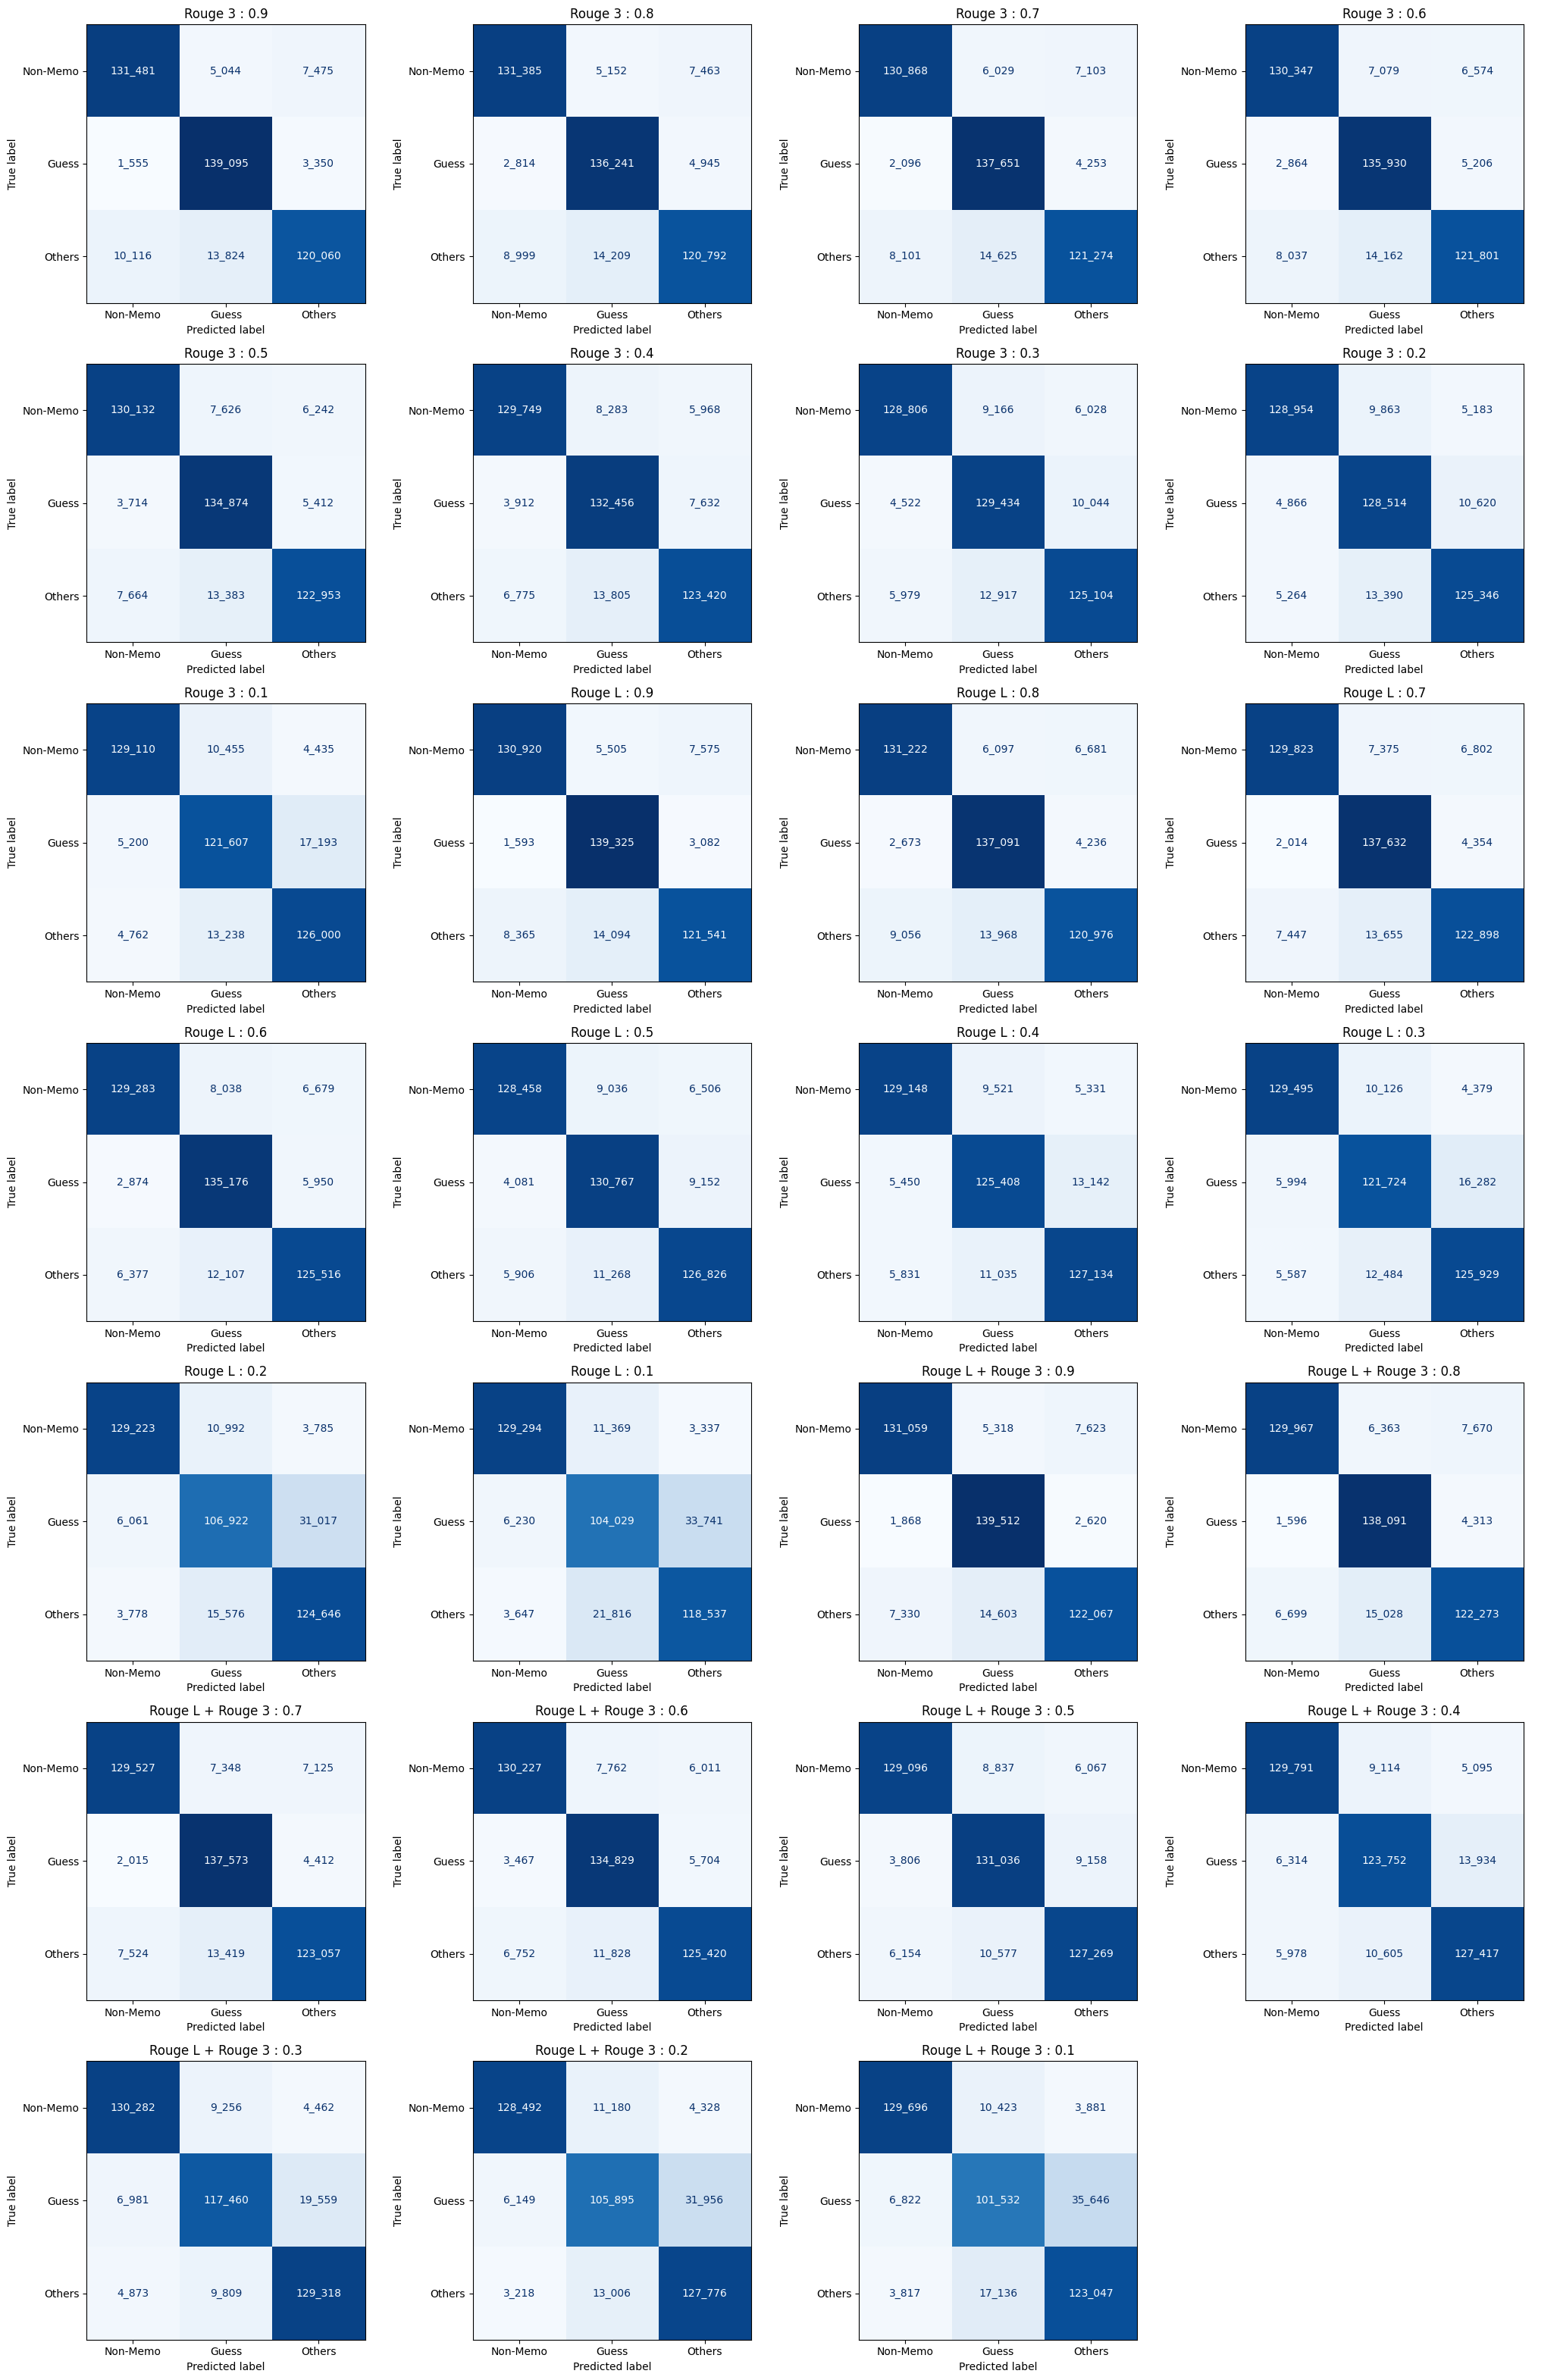

In [15]:
conf_matrix_to_plot = {
    (rouge_type, rouge_threshold) :v
    for (rouge_type, rouge_threshold), v in conf_matrix_per_type_per_threshold.items()
}

num_confusions = len(conf_matrix_to_plot)

n_cols = 4
n_rows = (num_confusions - 1) // n_cols + 1
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5.2*n_cols, 4.5*n_rows))

global_min = min(np.min(conf_matrix) for conf_matrix in conf_matrix_to_plot.values())
global_max = max(np.max(conf_matrix) for conf_matrix in conf_matrix_to_plot.values())

used_ax_idx = []

for idx_confusion, (rouge_type, rouge_threshold) in enumerate(sorted(conf_matrix_to_plot, reverse=True)):

    used_ax_idx.append(idx_confusion)

    conf_matrix = conf_matrix_to_plot[rouge_type, rouge_threshold]
    idx_col = idx_confusion % n_cols
    idx_row = idx_confusion // n_cols 
    ax = ax=axs[idx_row, idx_col] if n_rows > 1 else axs[idx_col]

    display = ConfusionMatrixDisplay(
        confusion_matrix=conf_matrix,
        display_labels=get_titles(COMMON_TAX_NAME),
    )
    display.plot(
        cmap=plt.cm.Blues,
        values_format="_d",
        ax=ax,
        colorbar=False,
    )
    display.im_.set_clim(global_min, global_max)
    display.ax_.set_title(get_rouge_title(rouge_type, rouge_threshold))

for idx_to_off in range(n_cols * n_rows):
    if idx_to_off in used_ax_idx:
        continue
    
    idx_col = idx_to_off % n_cols
    idx_row = idx_to_off // n_cols 
    ax = ax=axs[idx_row, idx_col] if n_rows > 1 else axs[idx_col]

    ax.set_axis_off()


fig.tight_layout()
fig.show()
fig.savefig(paths.figures / "04_rouge_optimization.pdf")

## Evaluation metrics

In [16]:
min_f1 = {}
mean_f1 = {}
min_prec = {}
mean_prec = {}
min_rec = {}
mean_rec = {}

for idx_tax, (rouge_type, rouge_threshold) in enumerate(sorted(conf_matrix_per_type_per_threshold, reverse=True)):
    conf_matrix: np.ndarray = conf_matrix_per_type_per_threshold[rouge_type, rouge_threshold]
    
    # Precision
    num_sample = np.sum(conf_matrix, axis=0)
    precision = conf_matrix.diagonal() / num_sample

    # Recall
    num_sample = np.sum(conf_matrix, axis=1)
    recall = conf_matrix.diagonal() / num_sample
    
    # F1
    f1_score = 2 / (1/precision + 1/recall)

    # Flush
    min_f1[rouge_type, rouge_threshold] = np.min(f1_score)
    mean_f1[rouge_type, rouge_threshold] = np.mean(f1_score)
    min_prec[rouge_type, rouge_threshold] = np.min(precision)
    mean_prec[rouge_type, rouge_threshold] = np.mean(precision)
    min_rec[rouge_type, rouge_threshold] = np.min(recall)
    mean_rec[rouge_type, rouge_threshold] = np.mean(recall)

## Perf group by

In [17]:
# Group by "patterns_cfg"
df_grouped = df.groupby(["patterns_rouge_threshold"]).agg({
    "patterns_rouge_threshold": "first",
    "patterns_duplicates_threshold": "first",
    "tax_name": "first",
    "num_classes": "first",  # Same
    "patterns_size": "first",
    "eval_loss_1": "mean",
    "eval_loss_2": "mean",
    "eval_loss_3": "mean",
    "overall_accuracy_1": "mean",
    "overall_accuracy_2": "mean",
    "overall_accuracy_3": "mean",
    
}).reset_index(drop=True)

# Compute final mean values over steps 1, 2, 3
df_grouped["mean_eval_loss"] = df_grouped[["eval_loss_1", "eval_loss_2", "eval_loss_3"]].mean(axis=1)

# Keep only the required columns and remove some lines
df_final = df_grouped[["tax_name", "num_classes", "mean_eval_loss", "patterns_duplicates_threshold", "patterns_rouge_threshold"]]

## Adding eval metric

In [18]:
df_final = df_final.copy()
df_final["min_f1"] = [100*min_f1[int(patterns_rouge_threshold), patterns_rouge_threshold - int(patterns_rouge_threshold)] for patterns_rouge_threshold in df_final["patterns_rouge_threshold"]]
df_final["mean_f1"] = [100*mean_f1[int(patterns_rouge_threshold), patterns_rouge_threshold - int(patterns_rouge_threshold)] for patterns_rouge_threshold in df_final["patterns_rouge_threshold"]]
df_final["min_prec"] = [100*min_prec[int(patterns_rouge_threshold), patterns_rouge_threshold - int(patterns_rouge_threshold)] for patterns_rouge_threshold in df_final["patterns_rouge_threshold"]]
df_final["mean_prec"] = [100*mean_prec[int(patterns_rouge_threshold), patterns_rouge_threshold - int(patterns_rouge_threshold)] for patterns_rouge_threshold in df_final["patterns_rouge_threshold"]]
df_final["min_rec"] = [100*min_rec[int(patterns_rouge_threshold), patterns_rouge_threshold - int(patterns_rouge_threshold)] for patterns_rouge_threshold in df_final["patterns_rouge_threshold"]]
df_final["mean_rec"] = [100*mean_rec[int(patterns_rouge_threshold), patterns_rouge_threshold - int(patterns_rouge_threshold)] for patterns_rouge_threshold in df_final["patterns_rouge_threshold"]]

### Pretty names

In [22]:
def rouge_L_yes(thd):
    if int(thd) == 0 or int(thd) == 1:
        return "Yes"
    return "No"

def rouge_3_yes(thd):
    if int(thd) == 0 or int(thd) == 2:
        return "Yes"
    return "No"

In [29]:
df_final_pretty_names = df_final[["num_classes", "min_f1", "mean_f1", "min_prec", "mean_prec", "min_rec", "mean_rec", "mean_eval_loss", "patterns_rouge_threshold"]].copy()
df_final_pretty_names["tax_name"] = [get_rouge_title(int(thd), thd - int(thd)) for thd in df_final["patterns_rouge_threshold"]]
df_final_pretty_names["Rouge-L"] = [rouge_L_yes(thd) for thd in df_final["patterns_rouge_threshold"]]
df_final_pretty_names["Rouge-3"] = [rouge_3_yes(thd) for thd in df_final["patterns_rouge_threshold"]]
df_final_pretty_names["Threshold"] = [thd - int(thd) for thd in df_final["patterns_rouge_threshold"]]
df_final_pretty_names = df_final_pretty_names.drop(columns=["patterns_rouge_threshold", "tax_name", "num_classes"])
df_final_pretty_names = df_final_pretty_names.sort_values(by="min_f1", ascending=False)
df_final_pretty_names = df_final_pretty_names[["Rouge-L", "Rouge-3", "Threshold", "min_f1", "mean_f1", "min_prec", "mean_prec", "min_rec", "mean_rec", "mean_eval_loss"]]
dumpable = df_final_pretty_names.round(decimals=1)
dumpable["mean_eval_loss"] = df_final_pretty_names["mean_eval_loss"].round(decimals=4)
dumpable.to_csv(paths.figures / "04_rouge_table.csv", index=False)
df_final_pretty_names

,Rouge-L,Rouge-3,Threshold,min_f1,mean_f1,min_prec,mean_prec,min_rec,mean_rec,mean_eval_loss
5,Yes,Yes,0.6,89.224038,90.383869,87.313737,90.498318,87.097222,90.387963,0.024052
14,Yes,No,0.6,88.972691,90.270409,87.030086,90.403486,87.163889,90.271991,0.024111
4,Yes,Yes,0.5,88.845840,89.688539,87.096045,89.749601,88.381250,89.676157,0.024493
13,Yes,No,0.5,88.539674,89.378454,86.559962,89.452321,88.073611,89.363657,0.024924
15,Yes,No,0.7,88.398656,90.334013,86.745408,90.543598,85.345833,90.359491,0.023828
8,Yes,Yes,0.9,88.355108,90.840818,87.505096,91.068489,84.768750,90.888426,0.023049
6,Yes,Yes,0.7,88.341457,90.288040,86.884552,90.484505,85.456250,90.314120,0.023805
22,No,Yes,0.5,88.262678,89.790446,86.522584,89.941456,85.384028,89.805324,0.025052
17,Yes,No,0.9,88.010051,90.636616,87.667690,90.845923,84.403472,90.691204,0.023701
7,Yes,Yes,0.8,87.885257,90.326428,86.587201,90.554079,84.911806,90.354398,0.024554
